In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

## Define the neural networks

In [43]:
class Encoder(nn.Module):
    def __init__(self, B=100, R=10):
        # B: number of spectral bands
        # R: size of the abundance vector z
        super(Encoder, self).__init__()

        self.layer_1 = nn.Linear(B, 9*R, bias=False)
        self.layer_2 = nn.Linear(9*R, 6*R, bias=False)
        self.layer_3 = nn.Linear(6*R, 3*R, bias=False)
        self.layer_4 = nn.Linear(3*R, R, bias=False)

        self.batch_norm = nn.BatchNorm1d(R)

        self.threshold = nn.Parameter(2 * (torch.rand(R)-0.5) / np.sqrt(R))

        self.leakyRelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()

    
    def forward(self, input):
        x = self.layer_1(input)
        x = self.leakyRelu(x)

        x = self.layer_2(x)
        x = self.leakyRelu(x)

        x = self.layer_3(x)
        x = self.leakyRelu(x)

        x = self.layer_4(x)
        x = self.leakyRelu(x)

        x = self.batch_norm(x)
        x = self.relu(x)

        # Soft thresholding for the non negativity constraint (ANC)
        x = x - self.threshold
        x = self.relu(x)

        # Normalize to make the sum equal to 1 (ASC)
        x = nn.functional.normalize(x, p=1.0, dim=1)

        return x

In [44]:
class Decoder(nn.Module):
    def __init__(self, B=100, R=10, init_endmembers=None, freeze=False):
        # B: number of spectral bands
        # R: size of the abundance vector z
        super(Decoder, self).__init__()

        if init_endmembers is not None:
            self.W = nn.Parameter(init_endmembers, requires_grad=not freeze)
        else:
            self.W = nn.Parameter(torch.abs(torch.rand(R, B)) / np.sqrt(R), requires_grad=not freeze)

    
    def forward(self, input):
        return input @ self.W
    
    def projection(self):
        # Projected gradient descent step
        #self.W[self.W <0] = 0#nn.Parameter(torch.clamp_min(self.W, min=torch.zeros(1)))
        #with torch.no_grad():
        #self.W = nn.Parameter(torch.clamp_min(self.W, min=torch.zeros(1)))
        
        with torch.no_grad():
            self.W[self.W<0] = 0

In [45]:
class AutoEncoder(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder  = decoder
    
    def forward(self, input):
        return self.decoder(self.encoder(input))
    
    def projection(self):
        self.decoder.projection()

In [5]:
class Discriminator(nn.Module):
    def __init__(self, B=100, R=10):
        # B: number of spectral bands
        # R: size of the abundance vector z
        super(Discriminator, self).__init__()

        n_hidden_1 = max(B // 4, R + 2) + 3
        n_hidden_2 = max(B // 10, R + 1)

        self.layer_1 = nn.Linear(R, n_hidden_1, bias=False)
        self.layer_2 = nn.Linear(n_hidden_1, n_hidden_2, bias=False)
        self.layer_3 = nn.Linear(n_hidden_2, 1, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.layer_1(input)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.relu(x)

        x = self.layer_3(x)
        x = self.sigmoid(x)

        return x

In [58]:
class AAENet(nn.Module):
    
    def __init__(self, encoder, decoder, discrimator):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discrimator
    
    def forward(self, input):
        encoding = self.encoder(input)
        return self.decoder(encoding), self.discriminator(encoding)
    
    def projection(self):
        self.decoder.projection()
    
    def set_trainable_discriminator(self, trainable):
        for param in self.discriminator.parameters():
            param.requires_grad = trainable

In [6]:
a = torch.randn((2, 4))
b = torch.randn((2, 4))

nn.CosineSimilarity(dim=1)(a,b)

tensor([-0.8672, -0.1986])

In [7]:
class AngleDistanceLoss(nn.Module):
    def __init__(self):
        super(AngleDistanceLoss, self).__init__()
        self.cos_sim = nn.CosineSimilarity(dim=1)

    def forward(self, x, y):
        angles = torch.arccos(self.cos_sim(x, y))
        return angles.mean()


## Generate synthetic data

In [8]:
N_pixels = 2000
B = 50 # Number of spectral bands
R = 2 # Number of endmembers

abundances = nn.functional.normalize(nn.functional.relu(torch.randn((N_pixels, R))))
abundances = nn.functional.normalize(nn.functional.relu(1 + 0.5*torch.randn((N_pixels, R))))
endmembers = torch.abs(torch.randn((R, B)))

data = abundances @ endmembers
print(data.shape)

torch.Size([2000, 50])


### Naive gradient descent

100%|██████████| 500/500 [00:05<00:00, 89.00it/s] 


Final loss 0.11423526


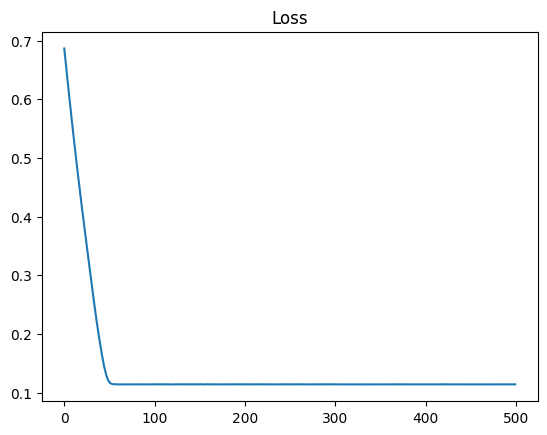

In [9]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-2, betas=(0.5, 0.9))

epochs = 500
losses = []

for e in tqdm(range(epochs)):
    opti.zero_grad()
    reconstruct = ae(data)
    #reconstruct = decoder(abundances)
    #loss = mse(reconstruct, data)
    loss = sad(reconstruct, data)
    loss.backward()
    opti.step()
    ae.projection()

    losses.append(loss.detach().numpy())

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

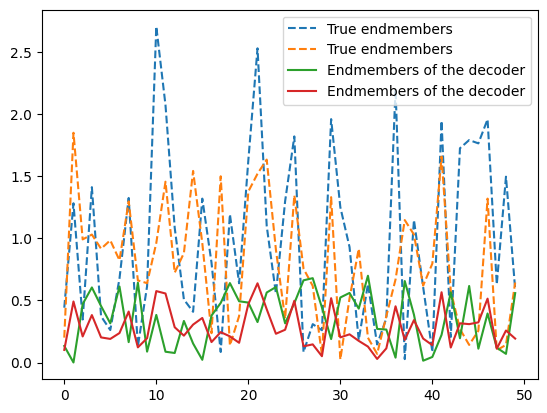

In [10]:
plt.plot(endmembers.numpy().T, label="True endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.legend()
plt.show()

### Alternate gradient descent (similar to PALM)

  1%|          | 4/500 [00:00<00:32, 15.22it/s]

100%|██████████| 500/500 [00:07<00:00, 63.77it/s]


Final loss 0.03875277


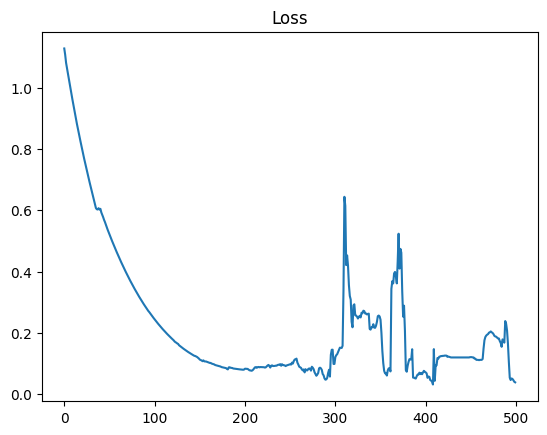

In [11]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
opti_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-2, betas=(0.5, 0.9))
opti_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-2, betas=(0.5, 0.9))

epochs = 500
losses = []

for e in tqdm(range(epochs)):
    opti_encoder.zero_grad()
    reconstruct = ae(data)
    loss = mse(reconstruct, data)
    loss.backward()
    opti_encoder.step()

    opti_decoder.zero_grad()
    reconstruct = ae(data)
    loss = mse(reconstruct, data)
    loss.backward()
    opti_decoder.step()
    ae.projection()

    losses.append(loss.detach().numpy())

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

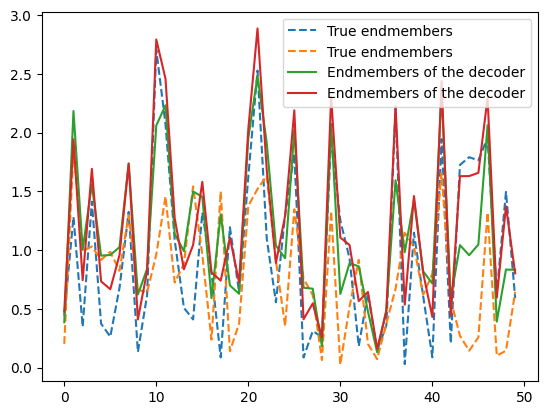

In [12]:
plt.plot(endmembers.numpy().T, label="True endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.legend()
plt.show()

In [13]:
decoder.projection()

In [14]:
torch.sum(decoder.W < 0)

tensor(0)

100%|██████████| 500/500 [00:04<00:00, 104.08it/s]


Final loss nan


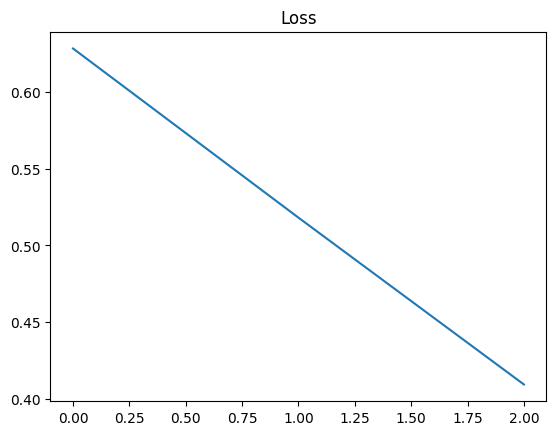

In [15]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
decoder.W = nn.Parameter(endmembers)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(encoder.parameters(), lr=1e-2, betas=(0.5, 0.9))

epochs = 500
losses = []

for e in tqdm(range(epochs)):
    opti.zero_grad()
    reconstruct = ae(data)
    #reconstruct = decoder(abundances)
    #loss = mse(reconstruct, data)
    loss = sad(reconstruct, data)
    loss.backward()
    opti.step()
    ae.projection()

    losses.append(loss.detach().numpy())

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

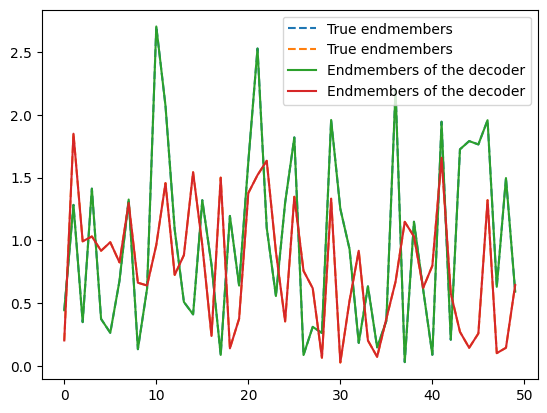

In [16]:
plt.plot(endmembers.numpy().T, label="True endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.legend()
plt.show()

## Real data

In [17]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
from munkres import Munkres
from scipy.io import loadmat

### Load and preprocess

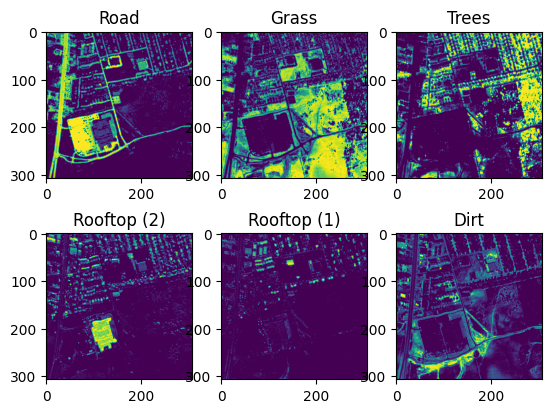

In [18]:
data = sci.loadmat('../data/Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations
#X = X[::10, ::10]
X /= X.max()

gt = sci.loadmat('../data/end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
names = ['Road','Grass','Trees','Rooftop (2)','Rooftop (1)','Dirt']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(names[ii])


In [19]:
def simpleVCA(X,r,optDisp=False): # TO DO. NB : simple parce qu'on gère mal les cas d'égalité (on peut gagner environ 0.06 sur l'angle)

    R = X.copy()
    
    
    K = np.zeros(r)
    
    for ii in range(r):
        c = np.random.rand(X.shape[0])
        ctX = c.T @ R
        
        p = np.argmax(ctX)
        K[ii] = p
        Rp = np.expand_dims(R[:,p],axis=1)
        
        if optDisp == True:
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(R[0,:],R[1,:],R[2,:])
        
        R = R - (Rp@Rp.T /(np.sum(Rp.squeeze()**2)))@R
        
    print('Max residual %s'%np.max(R))
    
    return K.astype(int)

Max residual 0.15737068900272969


Text(0.5, 1.0, 'Estimation by VCA')

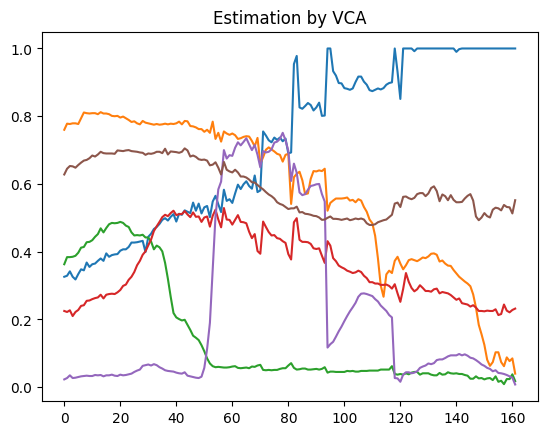

In [20]:
K_VCA = simpleVCA(X,6)

VCA_endmembers = X[:,K_VCA]

plt.figure(),plt.plot(VCA_endmembers)
plt.title('Estimation by VCA')

In [21]:
X.shape, VCA_endmembers.shape

((162, 94249), (162, 6))

kmeans clustering

In [22]:
X

array([[0.109, 0.116, 0.119, ..., 0.016, 0.012, 0.009],
       [0.113, 0.119, 0.119, ..., 0.019, 0.016, 0.013],
       [0.118, 0.13 , 0.127, ..., 0.028, 0.025, 0.023],
       ...,
       [0.259, 0.266, 0.289, ..., 0.077, 0.062, 0.047],
       [0.237, 0.256, 0.275, ..., 0.076, 0.066, 0.057],
       [0.264, 0.307, 0.275, ..., 0.061, 0.05 , 0.072]])

In [23]:
from sklearn.cluster import KMeans

K = 200
kmeans = KMeans(n_clusters=K, n_init=3)

kmeans.fit(X[:, ::5].T)


KMeans(n_clusters=200, n_init=3)

In [24]:
superpixels_indices = kmeans.predict(X.T)
print(superpixels_indices.shape)

(94249,)


In [25]:
batches = []
batch_size = 32


for k in range(K):
    pixel_indices = np.nonzero(superpixels_indices==k)[0]

    if pixel_indices.size >= 32:
        subsample = np.random.choice(pixel_indices.size, size=batch_size, replace=False)

        batches.append(torch.tensor(X[:, pixel_indices[subsample]].T, dtype=torch.float))

In [56]:
means = []
sqrt_covariances = []
eps = 1e-5
nb_none = 0
for batch in batches[:2]:
    mean = batch.mean(axis=0)
    means.append(mean)

    centered_batch = batch - mean
    cov = centered_batch.T @ centered_batch
    try:
        sqrt = np.linalg.cholesky(cov + np.eye(len(mean))*eps)
    except:
        sqrt = None
        nb_none += 1
        print(np.linalg.det(cov))
        print(np.linalg.eigvals(cov))
    sqrt_covariances.append(sqrt)
print(nb_none)


0


In [55]:
np.linalg.det(cov)

0.0

In [26]:
print(len(batches))

194


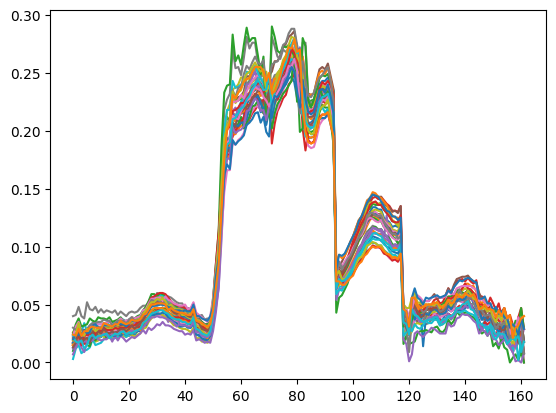

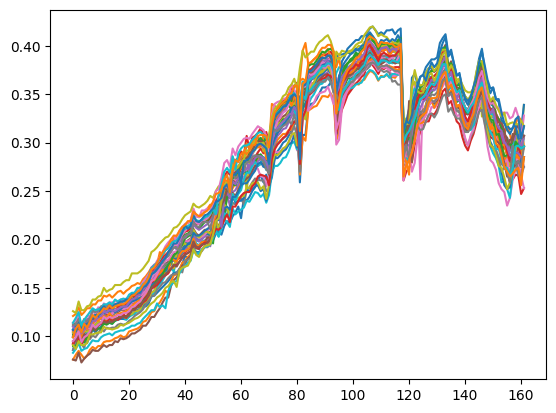

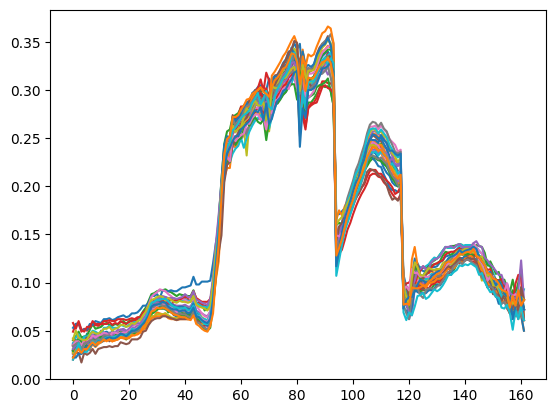

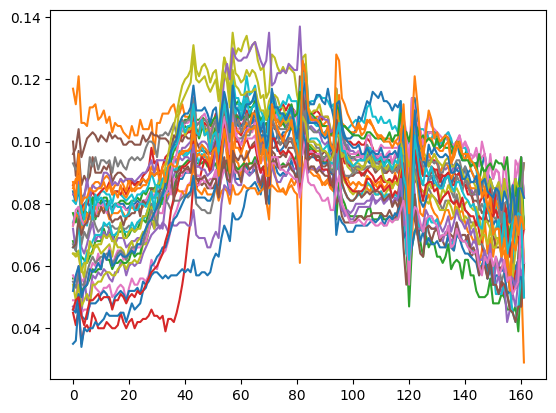

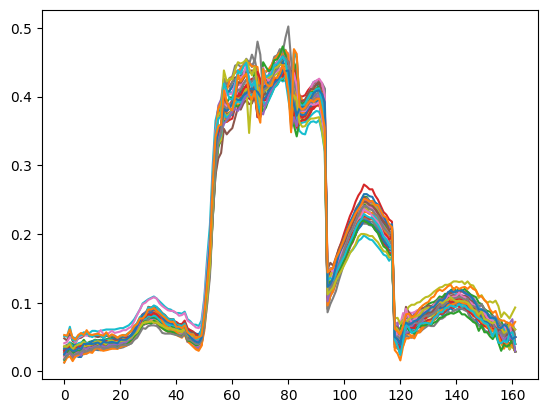

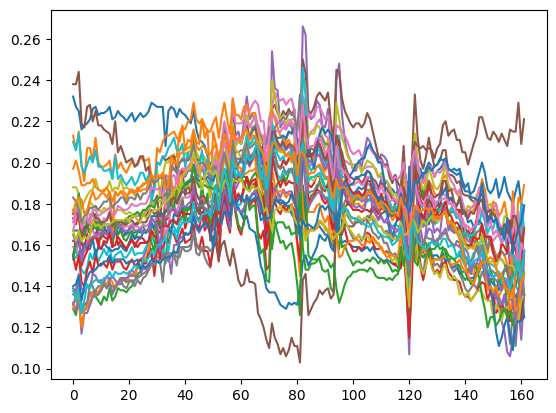

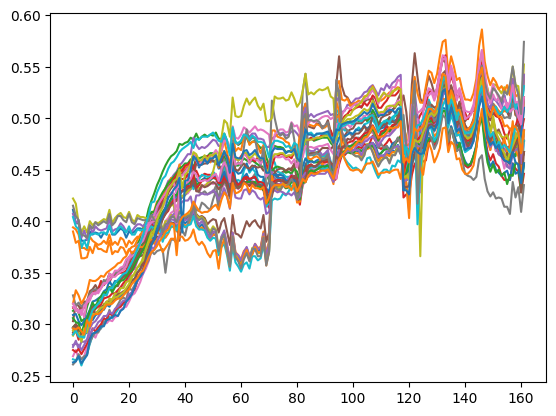

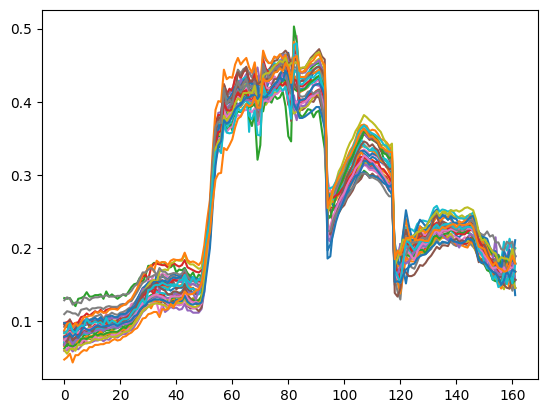

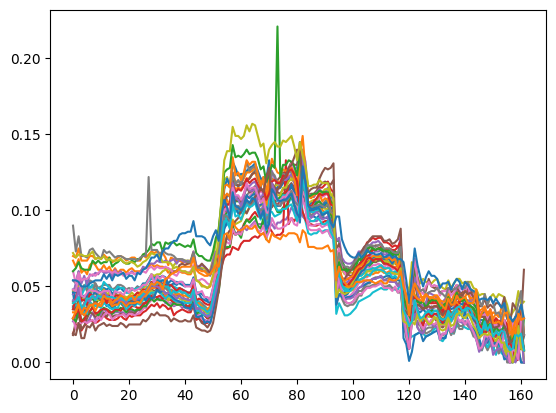

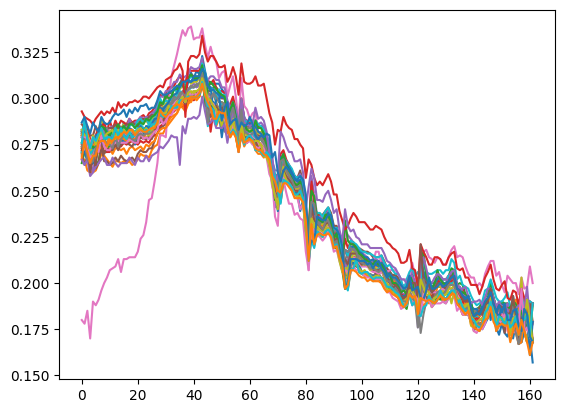

In [27]:
for i in range(10):
    plt.plot(batches[i].detach().numpy().T)
    plt.show()

## Train the AAENet without adversarial regularization

### Random decoder initialization

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

Final loss 0.09905133


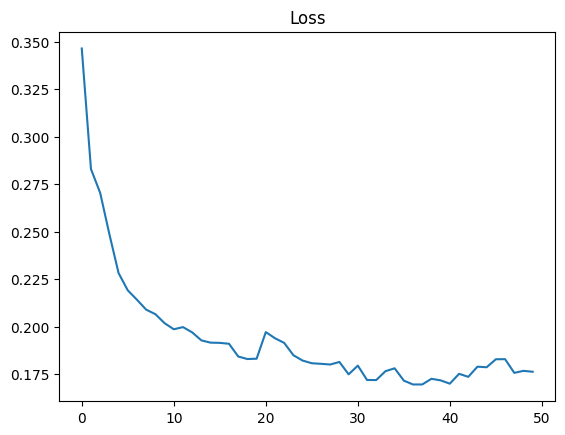

In [46]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.5, 0.9))

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

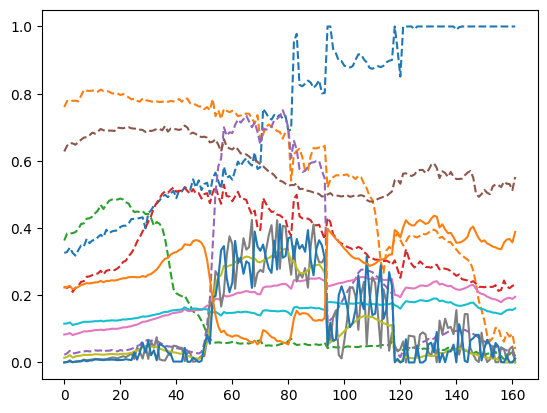

In [47]:
plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
#plt.legend()
plt.show()

### Using VCA as initialization for decoder

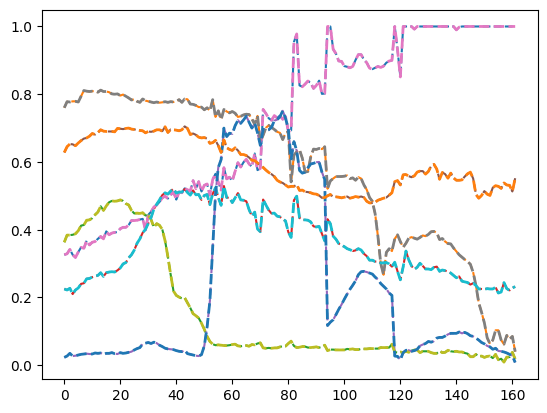

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

Final loss 0.08597009


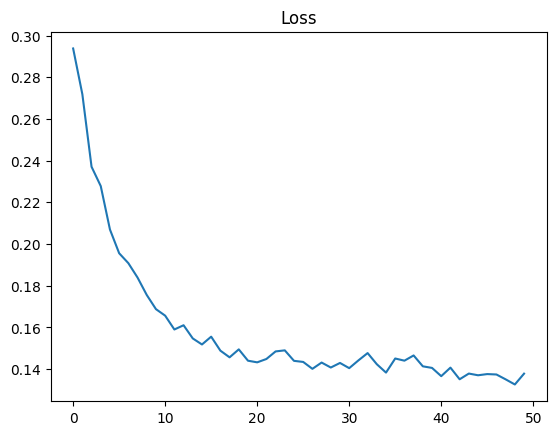

In [48]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float))

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

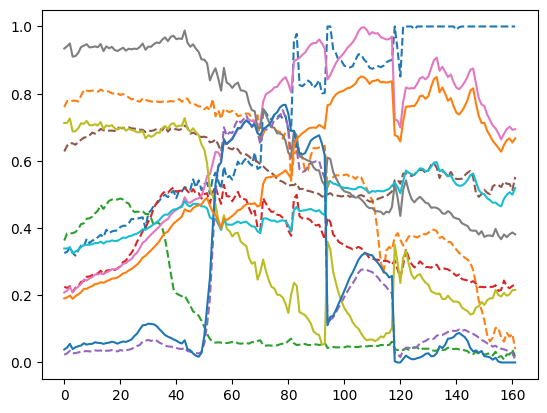

In [49]:
plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.show()

### Initialize with VCA and freeze decoder

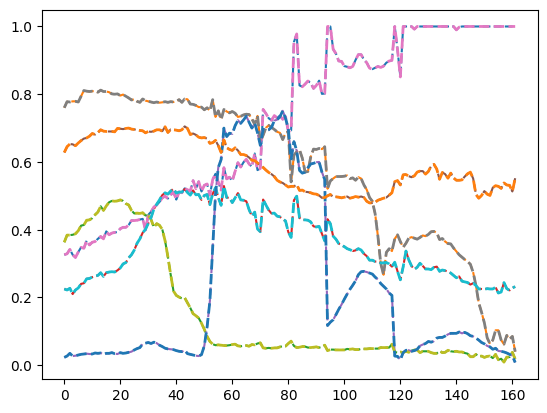

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]

Final loss 0.147084


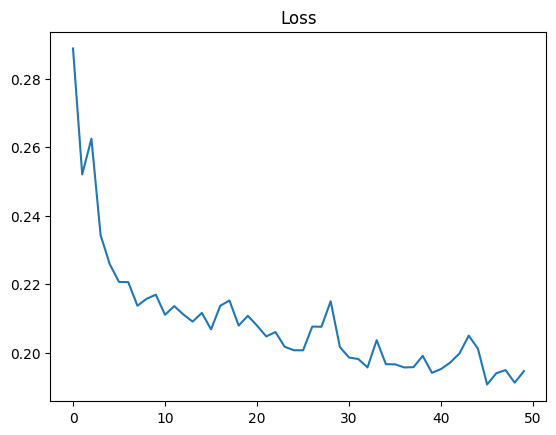

In [50]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=True)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

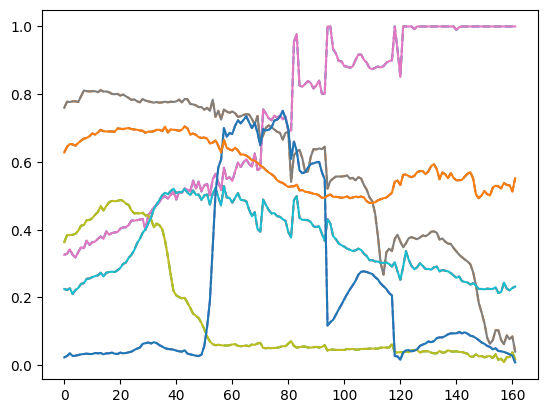

In [51]:
plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.show()

## Train with adversarial regularization

Not finished

In [ ]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)
discriminator = Discriminator(B=B, R=R)

ae = AAENet(encoder, decoder, discriminator)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers, label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct,  = ae(batches[b])
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()